In [1]:
# ! pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd 

In [3]:
df = pd.read_excel('MCAP31032023_0.xlsx')
sym_comp = df['Symbol']
sym_comp.dropna(inplace=True)
sym_comp.isna().sum()
tickers = []
tickers.extend(sym_comp.values)

In [4]:
tcs_test = pd.read_csv('stocksdata_test.csv')
dic = {'year':[],'month':[],'date':[]}
lth = len(tcs_test.Date)
for i in range(lth):
    lst = tcs_test.Date[i].split(sep='-')
    dic['date'].append(lst[2])
    dic['month'].append(lst[1])
    dic['year'].append(lst[0])

dft = pd.DataFrame(dic)
dft.index
tcs_test['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime 
print(tcs_test.info())
tcs_test.set_index('Date',inplace=True)
print(tcs_test.head())
tcs_test.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       125 non-null    datetime64[ns]
 1   Open       125 non-null    float64       
 2   High       125 non-null    float64       
 3   Low        125 non-null    float64       
 4   Close      125 non-null    float64       
 5   Adj Close  125 non-null    float64       
 6   Volume     125 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 7.0 KB
None
            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2023-04-03  3.42  3.47  3.36   3.44       3.44  291300
2023-04-04  3.45  3.46  3.28   3.32       3.32  581200
2023-04-05  3.30  3.30  3.11   3.19       3.19  524200
2023-04-06  3.16  3.31  3.11   3.18       3.18  562100
2023-04-10  3.15  3.33  3.15   3.32       3.32  249100


/tmp/ipykernel_13687/3887871701.py:12: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  tcs_test['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-25,2.02,2.02,1.92,1.96,1.96,515600
2023-09-26,1.98,1.98,1.85,1.87,1.87,510500
2023-09-27,1.86,2.01,1.85,2.00,2.00,1216400
2023-09-28,2.01,2.20,1.97,2.19,2.19,406400
2023-09-29,2.20,2.27,2.20,2.25,2.25,323000


In [5]:
# df = yf.download(tickers[1],period='6mo')
# f = open('stocksdata.csv','w')
# df.to_csv('stocksdata.csv')
# f.close()
df = pd.read_csv('stocksdata_acc.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-01,8.71,8.88,8.55,8.64,8.64,528800
1,2022-03-02,8.67,8.72,8.49,8.59,8.59,731700
2,2022-03-03,8.68,8.91,8.61,8.72,8.72,761900
3,2022-03-04,8.72,8.74,8.22,8.35,8.35,297700
4,2022-03-07,8.37,8.37,7.97,7.99,7.99,503100
...,...,...,...,...,...,...,...
268,2023-03-24,3.30,3.35,3.23,3.34,3.34,214600
269,2023-03-27,3.39,3.39,3.23,3.31,3.31,372900
270,2023-03-28,3.29,3.37,3.20,3.25,3.25,458400
271,2023-03-29,3.31,3.31,3.20,3.29,3.29,516600


In [6]:
dic = {'year':[],'month':[],'date':[]}
lth = len(df.Date)
for i in range(lth):
    lst = df.Date[i].split(sep='-')
    dic['date'].append(lst[2])
    dic['month'].append(lst[1])
    dic['year'].append(lst[0])


In [7]:
dft = pd.DataFrame(dic)
dft.index

RangeIndex(start=0, stop=273, step=1)

In [8]:
df['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       273 non-null    datetime64[ns]
 1   Open       273 non-null    float64       
 2   High       273 non-null    float64       
 3   Low        273 non-null    float64       
 4   Close      273 non-null    float64       
 5   Adj Close  273 non-null    float64       
 6   Volume     273 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 15.1 KB
None


/tmp/ipykernel_13687/1526783389.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(dft['date'].astype(str)+'-'+dft['month'].astype(str)+'-'+dft['year'].astype(str),dayfirst=True,infer_datetime_format=True) # feature type is not datetime


## __Time_Series_Analysis__

In [9]:
df.set_index('Date',inplace=True)
print(df.head())
df.tail()

            Open  High   Low  Close  Adj Close  Volume
Date                                                  
2022-03-01  8.71  8.88  8.55   8.64       8.64  528800
2022-03-02  8.67  8.72  8.49   8.59       8.59  731700
2022-03-03  8.68  8.91  8.61   8.72       8.72  761900
2022-03-04  8.72  8.74  8.22   8.35       8.35  297700
2022-03-07  8.37  8.37  7.97   7.99       7.99  503100


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-24,3.30,3.35,3.23,3.34,3.34,214600
2023-03-27,3.39,3.39,3.23,3.31,3.31,372900
2023-03-28,3.29,3.37,3.20,3.25,3.25,458400
2023-03-29,3.31,3.31,3.20,3.29,3.29,516600
2023-03-30,3.35,3.38,3.26,3.29,3.29,324300


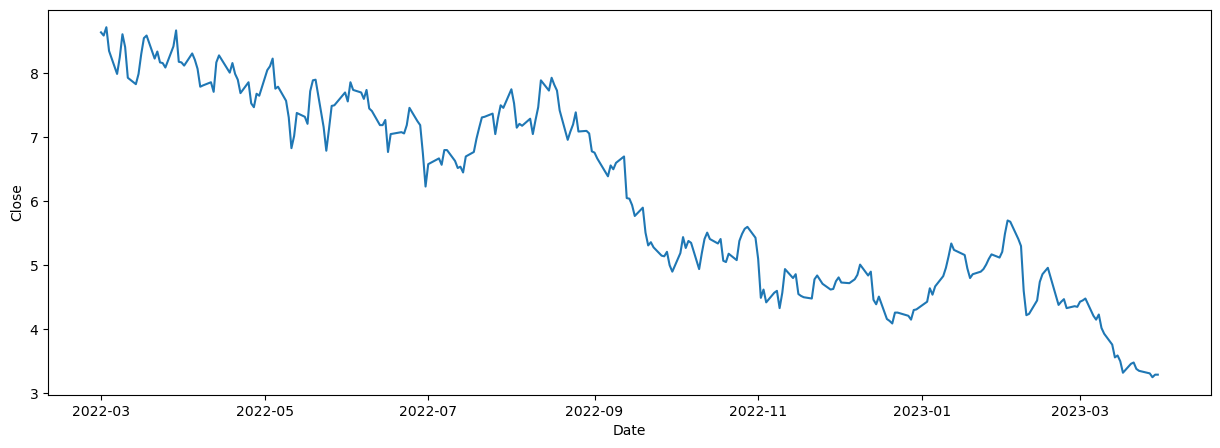

In [10]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
plt.show()

In [11]:
# calcaulate the plot of rolling mean and standard deviation
df['rollMean'] = df['Close'].rolling(window=20).mean() ## window = 12 parameter shiftes the time by 12 column
df['rollStd'] = df['Close'].rolling(window=20).std()

In [12]:
print(df['rollMean'])
print(df['rollStd']) # it will take rolling mean after first 12 values

Date
2022-03-01       NaN
2022-03-02       NaN
2022-03-03       NaN
2022-03-04       NaN
2022-03-07       NaN
               ...  
2023-03-24    3.8675
2023-03-27    3.8150
2023-03-28    3.7600
2023-03-29    3.7030
2023-03-30    3.6450
Name: rollMean, Length: 273, dtype: float64
Date
2022-03-01         NaN
2022-03-02         NaN
2022-03-03         NaN
2022-03-04         NaN
2022-03-07         NaN
                ...   
2023-03-24    0.434061
2023-03-27    0.434856
2023-03-28    0.433189
2023-03-29    0.415009
2023-03-30    0.385097
Name: rollStd, Length: 273, dtype: float64


In [13]:
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,rollMean,rollStd
Date,,,,,,,,
2022-03-01,8.71,8.88,8.55,8.64,8.64,528800,NaN,NaN
2022-03-02,8.67,8.72,8.49,8.59,8.59,731700,NaN,NaN
2022-03-03,8.68,8.91,8.61,8.72,8.72,761900,NaN,NaN
2022-03-04,8.72,8.74,8.22,8.35,8.35,297700,NaN,NaN
2022-03-07,8.37,8.37,7.97,7.99,7.99,503100,NaN,NaN


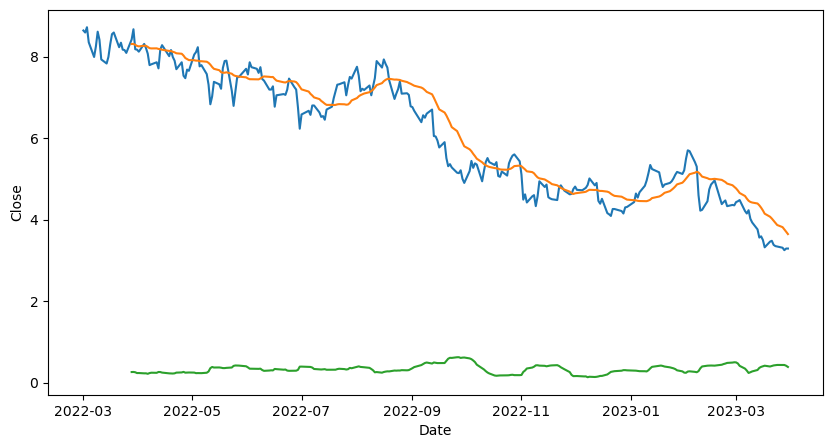

In [14]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
sns.lineplot(data=df,x=df.index,y=df['rollMean'])
sns.lineplot(data=df,x=df.index,y=df['rollStd'])
plt.show()

In [15]:
# conclusion : Mean is not stationary , SD is not stationary; so our data is not stationary
# Now let us perform the ADF test 

In [16]:
from statsmodels.tsa.stattools import adfuller
adfTest = adfuller(df['Close'])
adfTest
# Interpret these value below by converting into series

(-0.5542780798573949,
 0.8809823048111094,
 6,
 266,
 {'1%': -3.455175292841607,
  '5%': -2.8724677563219485,
  '10%': -2.57259315846006},
 -65.18633332050308)

In [17]:
stats = pd.Series(adfTest[0:4],index=['Test Statistics','p-value','#lags used','number of observation'])
stats

Test Statistics           -0.554278
p-value                    0.880982
#lags used                 6.000000
number of observation    266.000000
dtype: float64

In [18]:
for key, values in adfTest[4].items():
    print('critically',key,':',values)

critically 1% : -3.455175292841607
critically 5% : -2.8724677563219485
critically 10% : -2.57259315846006


In [19]:
def test_stationary(df,var):
    df['rollMean'] = df[var].rolling(window=12).mean() ## window = 12 parameter shiftes the time by 12 column
    df['rollStd'] = df[var].rolling(window=12).std()
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(df[var])
    stats = pd.Series(adfTest[0:4],index=['Test Statistics','p-value','#lags used','number of observation'])
    print(stats)
    for key, values in adfTest[4].items():
        print('critically',key,':',values)
    plt.figure(figsize=(10,5))
    sns.lineplot(data=df,x=df.index,y=var)
    sns.lineplot(data=df,x=df.index,y='rollMean')
    sns.lineplot(data=df,x=df.index,y='rollStd')
    plt.show()

Test Statistics           -0.554278
p-value                    0.880982
#lags used                 6.000000
number of observation    266.000000
dtype: float64
critically 1% : -3.455175292841607
critically 5% : -2.8724677563219485
critically 10% : -2.57259315846006


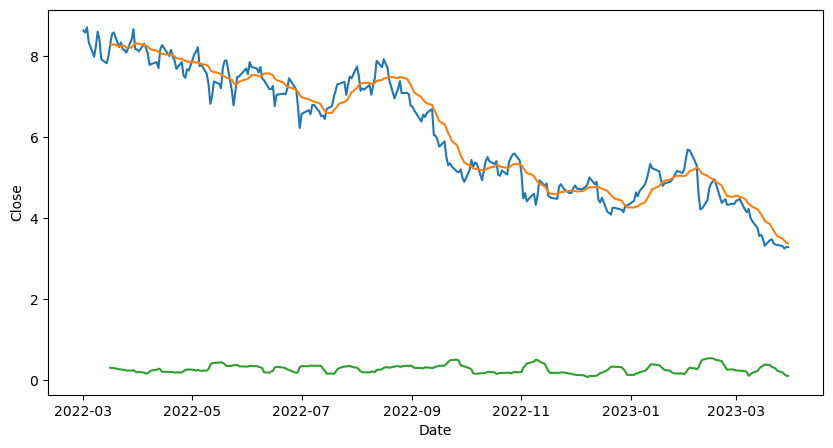

In [20]:
test_stationary(df,'Close')

In [21]:
tcs_df = df[['Close']].copy() # double bracket cuz its list within a list
tcs_df.head()

,Close
Date,
2022-03-01,8.64
2022-03-02,8.59
2022-03-03,8.72
2022-03-04,8.35
2022-03-07,7.99


In [22]:
def shift(x):
    tcs_df = df[['Close']].copy()
    tcs_df['shift'] = tcs_df.Close.shift(x) # create a new column which will contain shifted value from Close 
    tcs_df['shiftDiff'] = tcs_df['Close'] - tcs_df['shift']
    # print(tcs_df.sample(20))
    shifted_Data = tcs_df.dropna()
    return shifted_Data

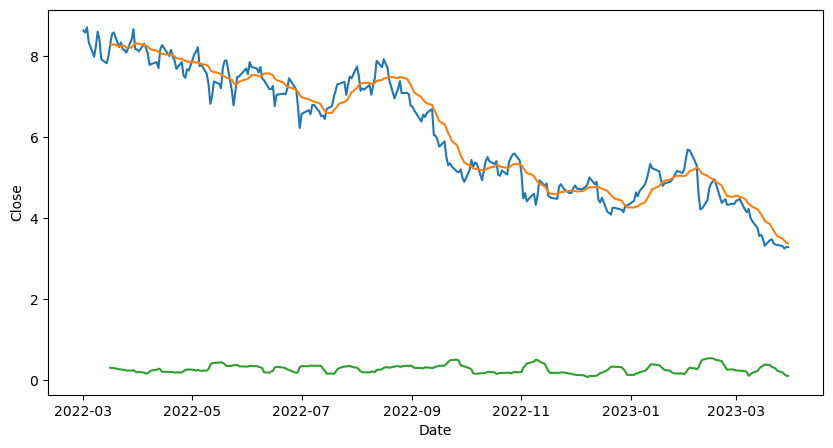

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df['Close'])
sns.lineplot(data=df,x=df.index,y=df['rollMean'])
sns.lineplot(data=df,x=df.index,y=df['rollStd'])
plt.show()

Test Statistics         -8.905291e+00
p-value                  1.142210e-14
#lags used               5.000000e+00
number of observation    2.660000e+02
dtype: float64
critically 1% : -3.455175292841607
critically 5% : -2.8724677563219485
critically 10% : -2.57259315846006


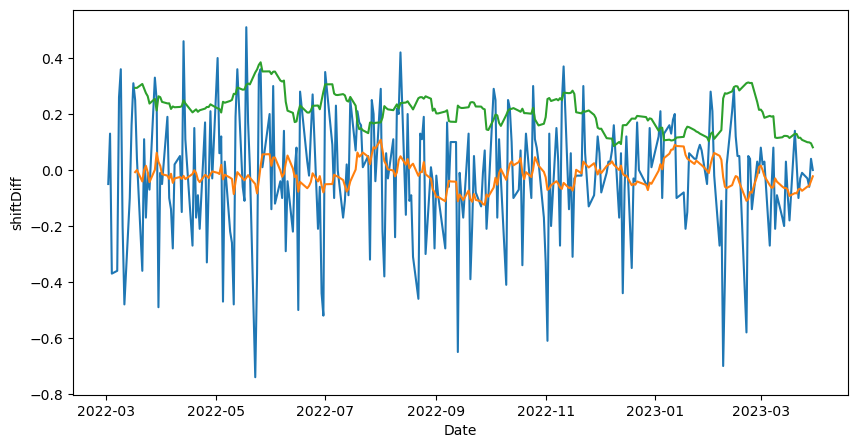

In [24]:
shifted_Data = shift(1)
test_stationary(shifted_Data,'shiftDiff')

# Interpret these value below by converting into series

### __ARIMA__

In [25]:
tcs = df[['Close']].copy(deep=True)
tcs['FirstDiff'] = tcs[['Close']].diff(1) # for ARIMA
#tcs['FirstDiff'] = tcs[['Close']].diff(12) # for

In [26]:
print(tcs.head())

            Close  FirstDiff
Date                        
2022-03-01   8.64        NaN
2022-03-02   8.59  -0.050000
2022-03-03   8.72   0.130000
2022-03-04   8.35  -0.370000
2022-03-07   7.99  -0.360001


In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

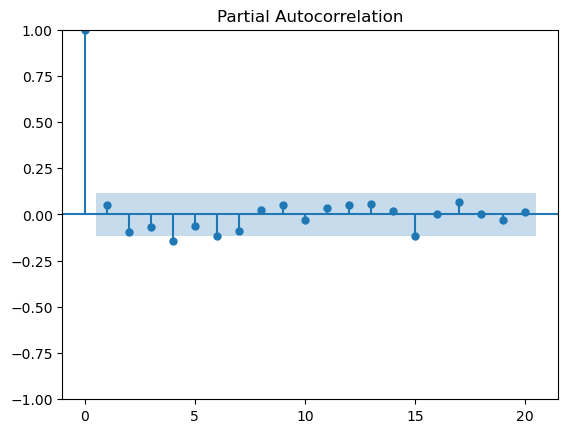

In [28]:
plot_pacf(tcs['FirstDiff'].dropna(),lags=20)
plt.show()

* the shaded area is insignificant area
* PACF gives us the auto regressive values
* frist 'p' is 1 (the axis co-ordinate), whoes value is ~0.31 (the y-axis co-ordinate)
* so, significant P values are 1 ,2 ,3, 4, etc  

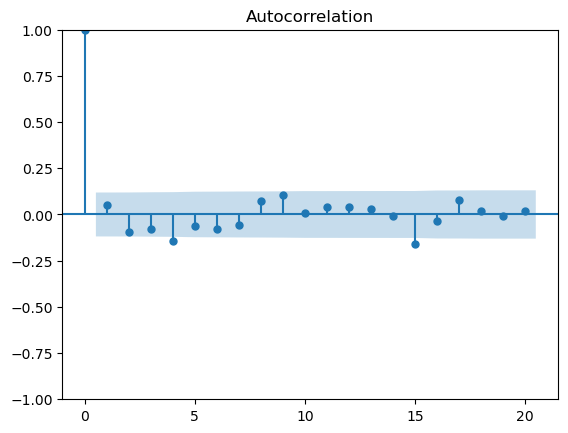

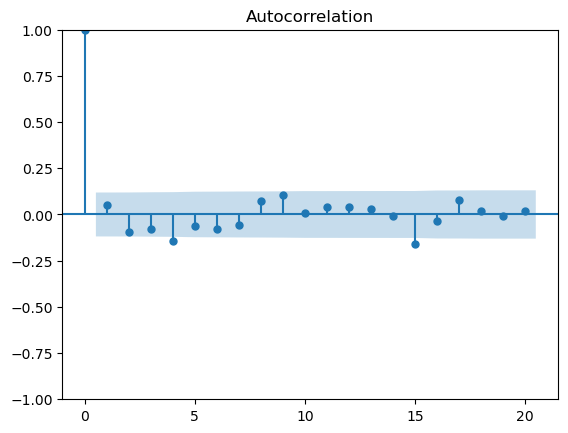

In [29]:
plot_acf(tcs['FirstDiff'].dropna(),lags=20)

In [30]:
tcs.sort_index()

,Close,FirstDiff
Date,,
2022-03-01,8.64,NaN
2022-03-02,8.59,-0.050000
2022-03-03,8.72,0.130000
2022-03-04,8.35,-0.370000
2022-03-07,7.99,-0.360001
...,...,...
2023-03-24,3.34,-0.010000
2023-03-27,3.31,-0.030000
2023-03-28,3.25,-0.060000


In [31]:
import itertools
p=d=q=range(5)
pdq = list(itertools.product(p,d,q))
lst = {}
for param in pdq:
    try:
        model_arima = ARIMA(tcs['Close'],order=param)
        model_arima_fit = model_arima.fit()
        lst[param] = model_arima_fit.aic
    except:
        continue
x = 0
pdq = 0
for k in lst.keys():
    if x > lst[k]:
        x = lst[k]
        pdq = k

/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasti

/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fail

            Close  FirstDiff  \
Date                           
2023-03-24   3.34      -0.01   
2023-03-27   3.31      -0.03   
2023-03-28   3.25      -0.06   
2023-03-29   3.29       0.04   
2023-03-30   3.29       0.00   

                                                    arimaPred  
Date                                                           
2023-03-24  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-27  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-28  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-29  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-30  <statsmodels.tsa.statespace.mlemodel.Predictio...  


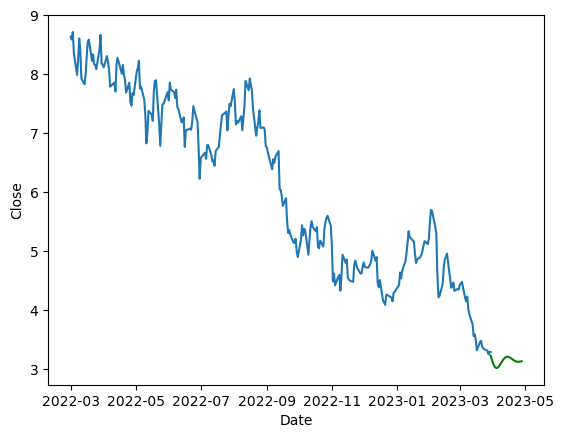

In [32]:
model = ARIMA(tcs['Close'],order=pdq) # Parameters: p, d, q
model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[0],end=test.index[-1], freq = None)
prediction = model_fit.get_forecast(steps = 30 , exog = df.iloc[-30:]['Close'])
tcs['arimaPred'] = prediction
print(tcs.tail())

# Plot

sns.lineplot(data=tcs,x=tcs.index,y='Close')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
plt.plot(pd.date_range(start = df.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Green')
plt.show()

# Conclusion: The ARIMA prediction is not good



In [33]:
# test.Date['2022-11-11']

            Close
Date             
2022-03-01   8.64
2022-03-02   8.59
2022-03-03   8.72
2022-03-04   8.35
2022-03-07   7.99


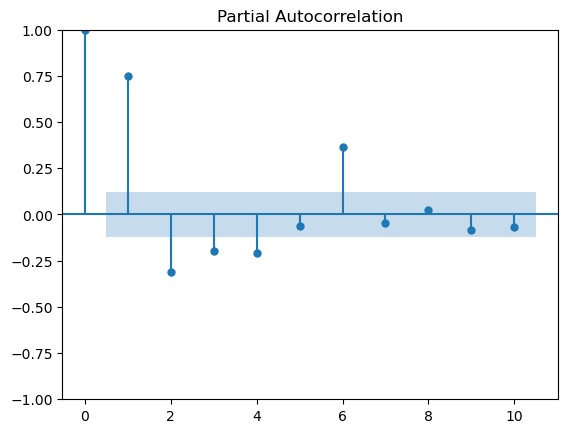

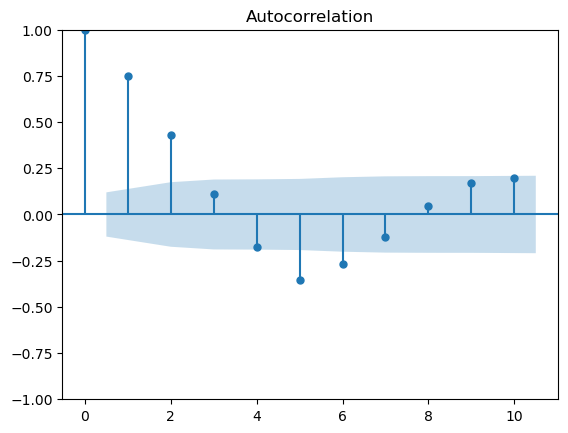

In [34]:
tcs = df[['Close']].copy(deep=True)
print(tcs.head())

# Create columns for one month and one year lagged data
tcs['firstDiff'] = tcs['Close'].diff()
tcs['Diff12'] = tcs['Close'].diff(5) # This will show nulls to start with

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(tcs['Diff12'].dropna(),lags=10)
plt.show() 

plot_acf(tcs['Diff12'].dropna(),lags=10)
plt.show()

In [41]:
train = tcs[:round(len(tcs)*70/100)] # Take the first 70% data
test = tcs[round(len(tcs)*70/100):] # Take the last 30% data, starting from 71%

# First ARIMA prediction
# model = ARIMA(train['Clorediction = model_fit.predict(start=test.index[0],end=test.index[-1])
# tcs['sarimaxPred'] = prediction
# print(tcs.tail()),order=(3,1,3)) # Parameters: p, d, q
# model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[0],end=test.index[-1])
# tcs['arimaPred'] = prediction

# Now SARIMAX prediction
model = SARIMAX(train['Close'],order=pdq , seasonal_order=(1,1,1,30))
model_fit = model.fit()
# prediction = model_fit.predict(start=test.index[1],end=test.index[-1])
prediction = model_fit.get_forecast(steps = 30 , exog = df.iloc[-30:]['Close'])
tcs['sarimaxPred'] = prediction
print(tcs.tail())


/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA para

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94735D-01    |proj g|=  8.82952D-01


 This problem is unconstrained.



At iterate    5    f=  1.36292D-01    |proj g|=  4.00902D-01

At iterate   10    f=  7.92166D-02    |proj g|=  9.74880D-02

At iterate   15    f=  7.40381D-02    |proj g|=  1.32942D-01

At iterate   20    f=  7.24934D-02    |proj g|=  6.94324D-03

At iterate   25    f=  7.22185D-02    |proj g|=  8.25083D-02

At iterate   30    f=  7.15918D-02    |proj g|=  1.05969D-02

At iterate   35    f=  7.15208D-02    |proj g|=  6.77364D-04

At iterate   40    f=  7.15184D-02    |proj g|=  4.11122D-04

At iterate   45    f=  7.15178D-02    |proj g|=  4.89905D-04


/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.15145D-02    |proj g|=  4.19585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   4.196D-04   7.151D-02
  F =   7.1514458597796468E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            Close  firstDiff  Diff12  \
Date                                   
2023-03-24   3.34      -0.01    0.02   
2023-03-27   3.31      -0.03   -0.15   
2023-03-28   3.25      -0.06   -0.23   
2023-03-29   3.29       0.04   -0.09   
2023-03-30   3.29       0.00   -0.06   

                                                  sarimaxPred  
Date            

/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  191
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 30)   Log Likelihood                 -13.659
Date:                              Tue, 10 Oct 2023   AIC                             43.319
Time:                                      11:07:24   BIC                             67.920
Sample:                                           0   HQIC                            53.308
                                              - 191                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5371      0.862      0.623      0.533      -1.153       2.227
ar.L2         -0.1475      0.540     -0.273      0.785      -1.206       0.911
ma.L1         -0.5580      0.850     -0.656      0.512      -2.224       1.108
ma.L2          0.0062      0.544      0.011      0.991      -1.059       1.072
ma.L3         -0.1102      0.203     -0.542      0.588      -0.509       0.289
ar.S.L30      -0.3039      0.104     -2.935      0.003      -0.507      -0.101
ma.S.L30      -0.8837      0.482     -1.835      0.067      -1.828       0.060
sigma2         0.0493      0.019      2.531      0.011       0.011       0.087
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.73
Prob(Q):                              0.91   Prob(JB):                         0.26
Heteroskedasticity (H):               0.69   Skew:                            -0.26
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
tcs

,Close,firstDiff,Diff12,sarimaxPred
Date,,,,
2022-03-01,8.64,NaN,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-02,8.59,-0.050000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-03,8.72,0.130000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-04,8.35,-0.370000,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
2022-03-07,7.99,-0.360001,NaN,<statsmodels.tsa.statespace.mlemodel.Predictio...
...,...,...,...,...
2023-03-24,3.34,-0.010000,0.02,<statsmodels.tsa.statespace.mlemodel.Predictio...
2023-03-27,3.31,-0.030000,-0.15,<statsmodels.tsa.statespace.mlemodel.Predictio...
2023-03-28,3.25,-0.060000,-0.23,<statsmodels.tsa.statespace.mlemodel.Predictio...


            Close  firstDiff  Diff12  \
Date                                   
2022-03-01   8.64        NaN     NaN   
2022-03-02   8.59  -0.050000     NaN   
2022-03-03   8.72   0.130000     NaN   
2022-03-04   8.35  -0.370000     NaN   
2022-03-07   7.99  -0.360001     NaN   

                                                  sarimaxPred  
Date                                                           
2022-03-01  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-02  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-03  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-04  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2022-03-07  <statsmodels.tsa.statespace.mlemodel.Predictio...  


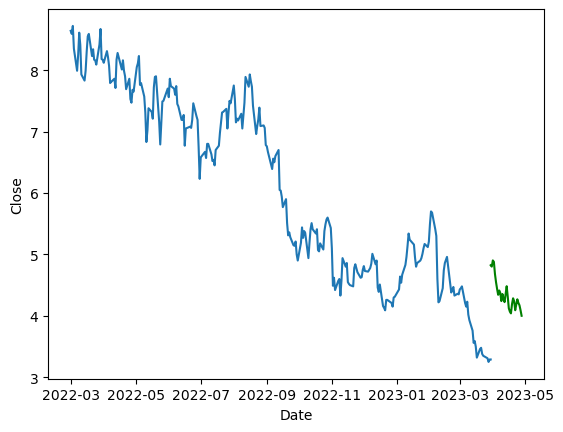

In [38]:
# Data looks better

# Plot
tcs.dropna()
print(tcs.head())
sns.lineplot(data=tcs,x=tcs.index,y='Close')
plt.plot(pd.date_range(start = df.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Green')
# sns.lineplot(data=tcs,x=tcs.index,y='sarimaxPred')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
plt.show()

In [39]:
# Compared to ARIMA, SARIMAX is much better

# Future prediction

# First check the last date in our dataset
print(tcs.tail())

# MS: Month Start frequency
# Create a data frame to hold index values from 01.01.61 to 01.12.62
futureDate = pd.DataFrame(pd.date_range(start='2023-01-07', end='2023-10-09',freq='D'),columns=['Dates'])
# futureDate.set_index('Dates',inplace=True)
print(futureDate.head())

# Predict and print
predict = model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1])
print(predict)

            Close  firstDiff  Diff12  \
Date                                   
2023-03-24   3.34      -0.01    0.02   
2023-03-27   3.31      -0.03   -0.15   
2023-03-28   3.25      -0.06   -0.23   
2023-03-29   3.29       0.04   -0.09   
2023-03-30   3.29       0.00   -0.06   

                                                  sarimaxPred  
Date                                                           
2023-03-24  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-27  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-28  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-29  <statsmodels.tsa.statespace.mlemodel.Predictio...  
2023-03-30  <statsmodels.tsa.statespace.mlemodel.Predictio...  
       Dates
0 2023-01-07
1 2023-01-08
2 2023-01-09
3 2023-01-10
4 2023-01-11
0      0.000000
1      8.640000
2      8.590000
3      8.720000
4      8.350000
         ...   
271    2.859717
272    2.927650
273    2.887656
274    2.766063
275    2.903367
Name: predicted_m

/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/dai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


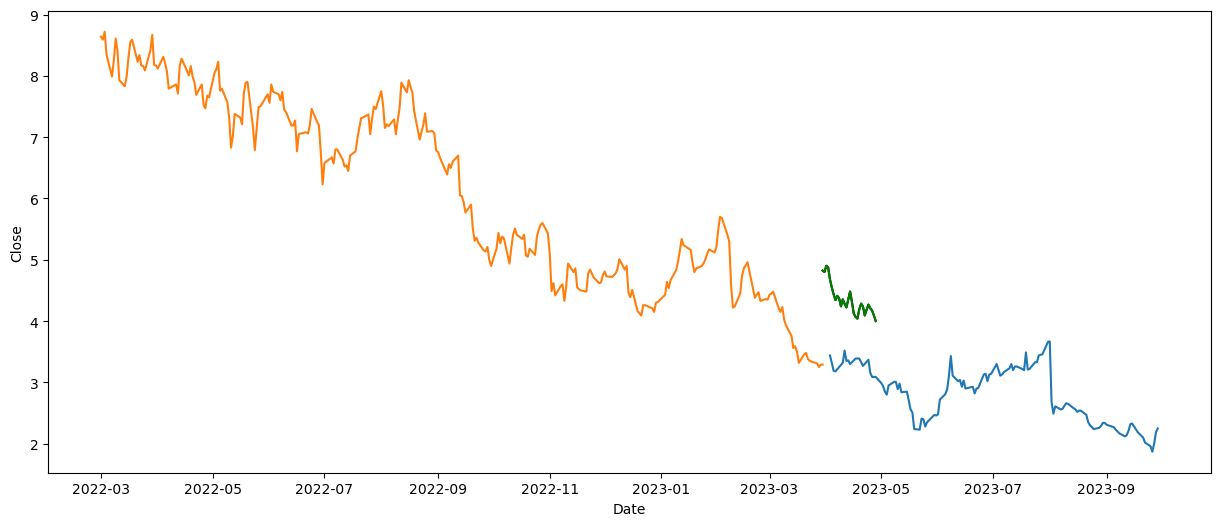

In [43]:

# Plot

tcs.dropna()
plt.figure(figsize=(15,6))
sns.lineplot(data=tcs_test,x=tcs_test.index,y='Close')
sns.lineplot(data=tcs,x=tcs.index,y='Close')
plt.plot(pd.date_range(start = tcs.index[-1],periods = 30 , freq = 'd'),prediction.predicted_mean , label = "test",color = 'Black')
# sns.lineplot(data=tcs,x=tcs.index,y='arimaPred')
# model_fit.predict(start=futureDate.index[0],end=futureDate.index[-1],step = 30).plot(color='black')
plt.show()
